In [84]:
import logging
logging.basicConfig(filename='regressing-manski.log', level=logging.INFO)

In [85]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/dryrun/'

In [86]:
col_name = 'Calcium'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [87]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [88]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [89]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-train.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [91]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2][[
       'icustay_id', 'RR', 'HR', 'SysBP', 'MeanBP', 'DiaBP',
       'SpO2', 'Temp_C', 'FiO2_1', 'Potassium', 'Sodium', 'Chloride',
       'Glucose', 'BUN', 'Creatinine', 'Magnesium', 'Calcium', 'Ionised_Ca',
       'CO2_mEqL', 'SGOT', 'SGPT', 'Total_bili', 'Albumin', 'Hb', 'WBC_count',
       'Platelets_count', 'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2',
       'Arterial_BE', 'HCO3', 'Arterial_lactate']].reset_index()

# MIMICtable_filtered_t0 = MIMICtable_filtered_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[col_name]>0].reset_index()
# MIMICtable_filtered_t1 = MIMICtable_filtered_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
MIMICtable_filtered_t0 = MIMICtable_filtered_t0[MIMICtable_filtered_t0['icustay_id'].isin(MIMICtable_filtered_t1['icustay_id'])].reset_index()
# MIMIC_data_combined = MIMICtable_filtered_t0[['gender', 'age', 'icustay_id', f'{col_name}_t0']].merge(MIMICtable_filtered_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
# MIMIC_data_combined.head()

In [92]:
pulse_data_t0 = pulse_data[pulse_data['index']==1].reset_index(drop=True)
pulse_data_t1 = pulse_data[pulse_data['index']==2].reset_index(drop=True)
# pulse_data_t0 = pulse_data_t0.rename(columns={f'{col_name}':f'{col_name}_t0'})
# pulse_data_t1 = pulse_data_t1.rename(columns={f'{col_name}':f'{col_name}_t1'})
# pulse_data_combined = pulse_data_t0[['icustay_id', f'{col_name}_t0']].merge(pulse_data_t1[['icustay_id', f'{col_name}_t1']], on=['icustay_id'])
pulse_data_t0 = MIMICtable_filtered_t0[['gender', 'age', 'Weight_kg', 'icustay_id']].merge(pulse_data_t0, on=['icustay_id'])
pulse_data_t1 = MIMICtable_filtered_t0[['gender', 'age', 'Weight_kg', 'icustay_id']].merge(pulse_data_t1, on=['icustay_id'])
# pulse_data_combined.head()

# Supervised Learning of Actions - Logistic Regression


In [93]:
nra = 5
nr_reps = 2

In [94]:
MIMICtable_filtered_t0.head()

,level_0,index,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,0,0,1,65537,7.139723e+09,0.0,22799.404780,4.0,1.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.49355,29.994183,7235.0,3605.0,-3184.512267
1,1,5,1,3,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,...,0.0,0.663900,599.999991,0.00,0.00,6267.00000,0.000000,9490.0,4705.0,-3223.000000
2,2,10,1,65544,7.056917e+09,0.0,24000.436400,3.0,0.0,0.0,...,0.0,0.770925,938.636364,0.00,0.00,11332.00000,0.000000,8210.0,4105.0,3122.000000
3,3,15,1,98314,4.762714e+09,0.0,23940.093773,4.0,0.0,1.0,...,0.0,0.906504,287.500000,0.00,0.00,0.00000,0.000000,14490.0,7245.0,-14490.000000
4,4,20,1,14,4.264269e+09,0.0,30946.970000,2.0,0.0,0.0,...,0.0,0.647399,577.499991,0.00,0.00,0.00000,80.000000,1263.0,599.0,-1183.000000


In [95]:
x_columns = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'PaO2_FiO2', 'Temp_C', 'Sodium', 'SysBP', 'HR']

In [96]:
# #################   Convert training data and compute conversion factors    ######################
# logging.info('Processing raw data')
# # all 47 columns of interest
# colbin = ['gender']
# colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
#     'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
#     'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
#     'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
# # collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']


# MIMICraw = MIMIC_data_combined[['gender', 'age', f'{col_name}_t0']].copy()

# for col in MIMICraw:
#     if col in colbin:
#         MIMICraw[col] = MIMICraw[col] - 0.5
# #     elif col in colnorm:
#     else:
#         cmu = MIMICraw[col].mean()
#         csigma = MIMICraw[col].std()
#         MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
# #     else:
# #         log_values = np.log(0.1 + MIMICraw[col])
# #         dmu = log_values.mean()
# #         dsigma = log_values.std()
# #         MIMICraw[col] = (log_values - dmu)/dsigma    
# logging.info('Raw data processed')


In [97]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']


MIMICraw = MIMICtable_filtered_t0[['gender', 'age', 'Weight_kg'] + x_columns].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


In [98]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

pulseraw = pulse_data_t0[['gender', 'age', 'Weight_kg'] + x_columns].copy()

for col in pulseraw:
    if col in colbin:
        pulseraw[col] = pulseraw[col] - 0.5
    elif col in colnorm:
        cmu = pulseraw[col].mean()
        csigma = pulseraw[col].std()
        pulseraw[col] = (pulseraw[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')


## Create Actions


In [99]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable_filtered_t0)) # array of ones, by default
io[MIMICtable_filtered_t0['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable_filtered_t0['max_dose_vaso'].copy()
vc_nonzero = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable_filtered_t0.loc[io==1, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==2, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==3, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==4, 'input_1hourly'].median(), MIMICtable_filtered_t0.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable_filtered_t0.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable_filtered_t0.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [100]:
len(actionbloc)

5162

## Fitting models

In [103]:
from sklearn.linear_model import LogisticRegression
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')

for model in tqdm(range(nr_reps)):
    logging.info('Model: ' + str(model))
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)]
    Xtestmimic = MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)]
    Y = actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc']
    Ytest = actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc']
    clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
    acc_train = clf.score(X, Y)
    acc_test = clf.score(Xtestmimic, Ytest)
    modelsDf = modelsDf.append({'model': model, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


In [104]:
clf.predict_proba(Xtestmimic)

array([[3.84362340e-03, 4.97915647e-01, 1.03601544e-01, ...,
        5.02368014e-03, 1.40883544e-03, 5.76907275e-03],
       [1.04064818e-03, 5.74092081e-01, 6.88257784e-02, ...,
        7.79979615e-04, 7.04000133e-03, 6.60187070e-03],
       [6.79987266e-04, 5.91838786e-01, 6.28065579e-02, ...,
        7.91745127e-04, 1.16000927e-03, 1.46477421e-04],
       ...,
       [1.73091644e-02, 6.46795472e-01, 6.65754184e-02, ...,
        2.26219025e-03, 6.37901454e-03, 5.60908375e-04],
       [4.13172626e-03, 4.41653468e-01, 7.06195619e-02, ...,
        5.94976668e-03, 1.66611550e-02, 7.19833127e-03],
       [3.01695587e-03, 5.45896350e-01, 8.54242567e-02, ...,
        2.12985231e-03, 4.90043387e-03, 3.44015877e-03]])

In [105]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.511605,0.527859,0.0,"LogisticRegression(C=1.0, class_weight=None, d..."
1,0.510345,0.527369,1.0,"LogisticRegression(C=1.0, class_weight=None, d..."


# Fit $\pi(a_0\mid x_0)$ using Neural Net

In [106]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [107]:
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    Y = torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1
    Ytest = torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1
    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    loss_func = torch.nn.CrossEntropyLoss()
    policy = PolicyNetwork(input_dim=len(MIMICraw.columns), output_dim=25)
    optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)    
    for epoch in range(100):
        for data, label in trainloader:
            prediction = policy(data)     # input x and predict based on x
            loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    torch.save(policy.state_dict(), f'{models_dir}/policy_{model}')
    

100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


In [145]:
icuuniqueids = MIMICtable_filtered_t0['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
Y = torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1
Ytest = torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1
train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=len(MIMICraw.columns), output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)

In [146]:
losses = []

for epoch in tqdm(range(200)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 200/200 [00:09<00:00, 20.08it/s]


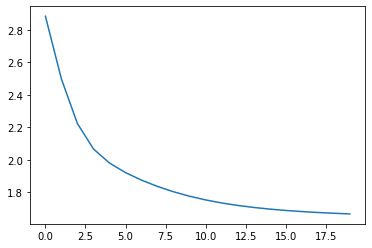

In [147]:
plt.plot(losses)

In [148]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtestmimic)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 53 %


# Regressing $\mathbb{E}[Y^{obs}\mid x,a]$

In [112]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [113]:
net = Net(n_feature=len(MIMICraw.columns)+1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [114]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    net = Net(n_feature=len(MIMICraw.columns)+1, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
    loss_func = torch.nn.MSELoss()
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/yobs_{model}')

100%|██████████| 2/2 [00:18<00:00,  9.26s/it]


In [115]:
import torch.utils.data as data_utils

grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

net = Net(n_feature=len(MIMICraw.columns)+1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [116]:
# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:10<00:00, 18.92it/s]


0.770239531993866

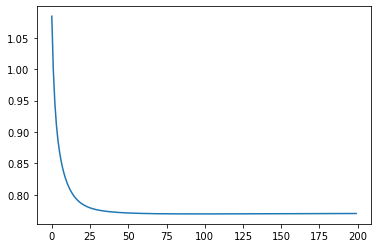

In [117]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [118]:
action = 1
row = 2
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)+2]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} val at t=1', net(torch.cat((Xtestmimic[row,:], action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean())


Calcium val at t=0 tensor(86.9689)
Calcium val at t=1 tensor([86.9902], grad_fn=<AddBackward0>)


# Regressing $\mathbb{E}[Y^{min}\mid x,a]$

In [119]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data


class QuantileNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(QuantileNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [120]:
class PinballLoss():
    def __init__(self, quantile=0.10, reduction='none'):
        self.quantile = quantile
        assert 0 < self.quantile
        assert self.quantile < 1
        self.reduction = reduction

    def __call__(self, output, target):
        assert output.shape == target.shape
        loss = torch.zeros_like(target, dtype=torch.float)
        error = output - target
        smaller_index = error < 0
        bigger_index = 0 < error
        loss[smaller_index] = self.quantile * (abs(error)[smaller_index])
        loss[bigger_index] = (1-self.quantile) * (abs(error)[bigger_index])

        if self.reduction == 'sum':
            loss = loss.sum()
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [121]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    quantile_net = QuantileNet(n_feature=len(MIMICraw.columns), n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
    loss_func = PinballLoss(quantile=0.001, reduction='mean')
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = quantile_net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymin_{model}')

100%|██████████| 2/2 [00:27<00:00, 13.58s/it]


In [122]:
quantile_net = QuantileNet(n_feature=len(MIMICraw.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.001, reduction='mean')

In [123]:
# train the network
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

quantile_net = QuantileNet(n_feature=len(MIMICraw.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.001, reduction='mean')    

# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = quantile_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(quantile_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:15<00:00, 12.99it/s]


0.009511603973805904

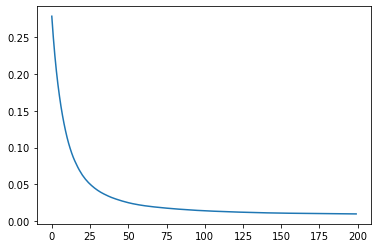

In [124]:
plt.plot(losses)
losses[-1]

In [125]:
action = 1
row = 1
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)+2]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} min val at t=1', quantile_net(Xtestmimic[row,:])*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

Calcium val at t=0 tensor(76.2175)
Calcium min val at t=1 tensor([59.4485], grad_fn=<AddBackward0>)


In [126]:
MIMICtable[col_name].median()

84.0

# Regressing $\mathbb{E}[Y^{max}\mid x,a]$

In [127]:
for model in tqdm(range(nr_reps)):
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(MIMICraw.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(MIMICraw[MIMICtable_filtered_t0['icustay_id'].isin(testidx)].values)
    ptid = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'icustay_id']
    ptidtestmimic = MIMICtable_filtered_t0.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'icustay_id']
    Y = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(MIMICtable_filtered_t1.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)

    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(X, Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(Xtestmimic, Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)

    quantile_net = QuantileNet(n_feature=len(MIMICraw.columns), n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
    loss_func = PinballLoss(quantile=0.999, reduction='mean')
    for epoch in range(200):
        for X, Y in trainloader:
            prediction = quantile_net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(quantile_net.state_dict(), f'{models_dir}/ymax_{model}')

100%|██████████| 2/2 [00:27<00:00, 13.94s/it]


In [128]:
quantile_net = QuantileNet(n_feature=len(MIMICraw.columns), n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(quantile_net.parameters(), lr=0.001)
loss_func = PinballLoss(quantile=0.999, reduction='mean')

In [129]:
# train the network
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = quantile_net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(quantile_net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())

100%|██████████| 200/200 [00:15<00:00, 12.64it/s]


0.01057497225701809

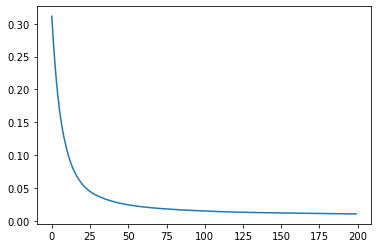

In [130]:
plt.plot(losses)
losses[-1]

In [131]:
action = 1
row = 3
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)+2]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} max val at t=1', quantile_net(Xtestmimic[row,:])*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

Calcium val at t=0 tensor(84.8186)
Calcium max val at t=1 tensor([111.2641], grad_fn=<AddBackward0>)


# Regressing $\mathbb{E}[Y^{sim}(a)\mid x]$

In [132]:
for model in tqdm(range(nr_reps)):
    icuuniqueids = pulse_data['icustay_id'].unique()
    grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
    crossval = 1
    trainidx = icuuniqueids[grp != crossval]
    testidx = icuuniqueids[grp == crossval]
    X = torch.FloatTensor(pulseraw.loc[pulse_data_t0['icustay_id'].isin(trainidx)].values)
    Xtestmimic = torch.FloatTensor(pulseraw[pulse_data_t0['icustay_id'].isin(testidx)].values)
    A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
    Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
    Y = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
    Ytest = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
    Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
    Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

    train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32)
    test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
    testloader = torch.utils.data.DataLoader(test, batch_size=32)
    
    net = Net(n_feature=len(pulseraw.columns) + 1, n_hidden=10, n_output=1)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
    loss_func = torch.nn.MSELoss()

    for epoch in range(200):
        for X, Y in trainloader:
            prediction = net(X)     # input x and predict based on x

            loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
    torch.save(net.state_dict(), f'{models_dir}/ysim_{model}')

100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


In [133]:
print('Pulseraw columns:', len(pulseraw.columns))
print('MIMICraw columns:', len(MIMICraw.columns))

Pulseraw columns: 19
MIMICraw columns: 19


In [134]:
net = Net(n_feature=len(pulseraw.columns) + 1, n_hidden=10, n_output=1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
loss_func = torch.nn.MSELoss()

In [135]:
icuuniqueids = pulse_data['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(pulseraw.loc[pulse_data_t0['icustay_id'].isin(trainidx)].values)
Xtestmimic = torch.FloatTensor(pulseraw[pulse_data_t0['icustay_id'].isin(testidx)].values)
A = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(trainidx), 'action_bloc'].values).to(torch.long)-1)/24
Atest = (torch.tensor(actionbloc.loc[MIMICtable_filtered_t0['icustay_id'].isin(testidx), 'action_bloc'].values).to(torch.long)-1)/24
Y = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(trainidx), f'{col_name}'].values).unsqueeze(dim=1)
Ytest = torch.FloatTensor(pulse_data_t1.loc[pulse_data_t1['icustay_id'].isin(testidx), f'{col_name}'].values).unsqueeze(dim=1)
Y = (Y - MIMICtable[col_name].mean())/MIMICtable[col_name].std()
Ytest = (Ytest - MIMICtable[col_name].mean())/MIMICtable[col_name].std()

train = data_utils.TensorDataset(torch.column_stack((X, A)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, Atest)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)


In [136]:
losses = []
for epoch in tqdm(range(200)):
    for X, Y in trainloader:
        prediction = net(X)     # input x and predict based on x

        loss = loss_func(prediction, Y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    with torch.no_grad():
        test_loss = 0
        for Xtest, Ytest in testloader:
            test_loss += loss_func(net(Xtest), Ytest)
        test_loss = test_loss/len(testloader)
        losses.append(test_loss.item())


100%|██████████| 200/200 [00:08<00:00, 22.91it/s]


0.02770368382334709

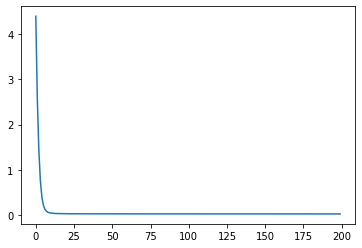

In [137]:
import matplotlib.pyplot as plt
plt.plot(losses)
losses[-1]

In [144]:
action = 1
row = 5
action_tensor = torch.FloatTensor(((action-1)/24,))
print(f'{col_name} val at t=0', Xtestmimic[row,x_columns.index(col_name)+2]*MIMICtable[col_name].std() + MIMICtable[col_name].mean())
print(f'{col_name} val at t=1', net(torch.cat((Xtestmimic[row,:], action_tensor)))*MIMICtable[col_name].std() + MIMICtable[col_name].mean())

Temp_C val at t=0 tensor(36.6531)
Temp_C val at t=1 tensor([33.1520], grad_fn=<AddBackward0>)


# Computing scores for simulated outcomes using saved models

In [139]:
def compute_score(gender, age, col_v, action, col_name, models_dir):
    softmax = torch.nn.Softmax(dim=0)
    gender = gender - 0.5
    age_normalized_sim = (age - pulse_data_combined['age'].mean())/pulse_data_combined['age'].std()
    col_normalized_sim = (col_v - pulse_data_t0[f'{col_name}'].mean())/pulse_data_t0[f'{col_name}'].std()
    sim_input = torch.FloatTensor((gender, age_normalized_sim, col_normalized_sim))
    age_normalized_obs = (age - MIMIC_data_combined['age'].mean())/MIMIC_data_combined['age'].std()
    col_normalized_obs = (col_v - MIMICtable_filtered_t0[f'{col_name}'].mean())/MIMICtable_filtered_t0[f'{col_name}'].std()
    obs_input = torch.FloatTensor((gender, age_normalized_obs, col_normalized_obs))
    action_tensor = torch.FloatTensor(((action-1)/24,))
    p = 0
    for i in range(nr_reps):
        yobs_model = Net(n_feature=4, n_hidden=10, n_output=1)
        yobs_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/yobs_{i}'))
        yobs_model.eval()
        ymax_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymax_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymax_{i}'))
        ymax_model.eval()
        ymin_model = Net(n_feature=3, n_hidden=10, n_output=1)
        ymin_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ymin_{i}'))
        ymin_model.eval()
        ysim_model = Net(n_feature=4, n_hidden=10, n_output=1)
        ysim_model.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/ysim_{i}'))
        ysim_model.eval()
        policy = PolicyNetwork(input_dim=3, output_dim=25)
        policy.load_state_dict(torch.load(f'{models_dir}/col_{col_name}/policy_{i}'))
        policy.eval()
        prob = softmax(policy(obs_input))[action-1]
        lb = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymin_model(obs_input))
        ub = prob*yobs_model(torch.cat((obs_input, action_tensor))) + (1-prob)*(ymax_model(obs_input))
        sim = ysim_model(torch.cat((sim_input, action_tensor)))
        p += int(((lb<=sim)&(sim<=ub)).item())
    p = p/nr_reps
    return p    

In [141]:
models_dir = "/data/localhost/taufiq/manski_bounds"
col_name = 'Temp_C'
compute_score(0, 65, 31, 0, col_name, models_dir)

In [ ]:
pulse_data_t0.head()

In [ ]:
ages = range(18,66)
scores = []
for age in tqdm(ages):
    score = compute_score(0, age, 32, 2)
    scores.append(score)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ages, scores)

In [ ]:
temps = range(29,35)
scores = []
for temp in tqdm(temps):
    score = compute_score(0, 40, temp, 1)
    scores.append(score)

In [ ]:
plt.plot(temps, scores)

In [ ]:
ages = np.linspace(18,65, num=65-18 + 1)
temps = np.linspace(29,36, num=(36-29)*5 + 1)
df = pd.DataFrame()
for age in tqdm(ages):
    for temp in temps:
        score = compute_score(0, age, temp, 2)
        df = df.append({'age': age, 'temp': temp, 'score': score}, ignore_index=True)

In [ ]:
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter

fig, axs = plt.subplots(1, 1, figsize=(15,12))
df_pivot = df.pivot_table(index="temp", columns="age", values="score", aggfunc=np.max)
df_pivot_smooth = gaussian_filter(df_pivot, sigma=0.1)
sns.heatmap(df_pivot_smooth, vmax=df_pivot.values.max(), xticklabels=ages, yticklabels=temps, vmin=df_pivot.values.min(), ax=axs)
plt.show()

In [ ]:
MIMICtable_filtered_t0['HR']

In [ ]:
pulse_data_t0['HR']